In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
# import sys
import os


args = ''
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# from uicsmodels.gaussianprocesses.likelihoods import AbstractLikelihood

# from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

Selected GPU 


2024-06-14 14:20:12.625591: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
import sys
sys.path.append('/home/davcic/CP_Testing')
from New_kernel_1 import Discontinuous_multiple

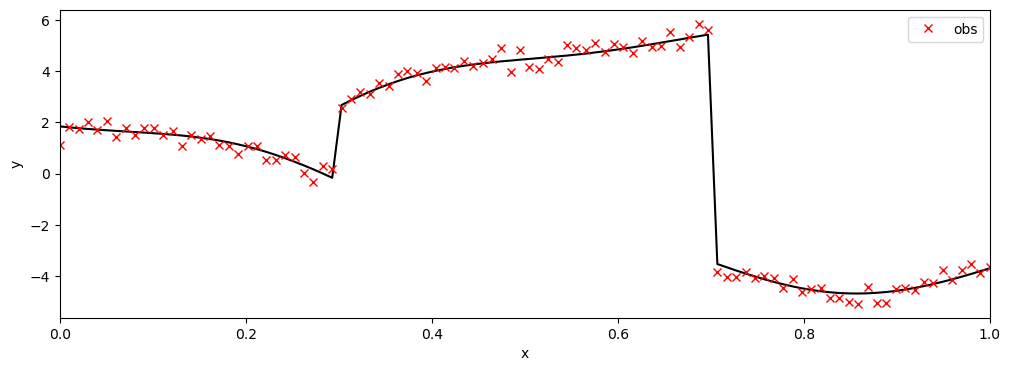

In [3]:
key = jrnd.PRNGKey(12345)

lengthscale_ = 0.2
output_scale_ = 5.0
obs_noise_ = 0.3
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

x0 = jnp.array([30, 70])/n
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num = x0),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    CP=x0,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [7]:
num_CP = len(x0)
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=dx.Uniform(low=jnp.zeros(num_CP),
                                        high=jnp.ones(num_CP))
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp()))
                                                       )

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [8]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
CPU times: user 35.2 s, sys: 22 s, total: 57.2 s
Wall time: 54.9 s


In [11]:
%%time
gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1000
# num_mcmc_steps = 300
key, gpl_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                mode='gibbs-in-smc',
                                                                sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 1min 38s, sys: 451 ms, total: 1min 38s
Wall time: 1min 35s


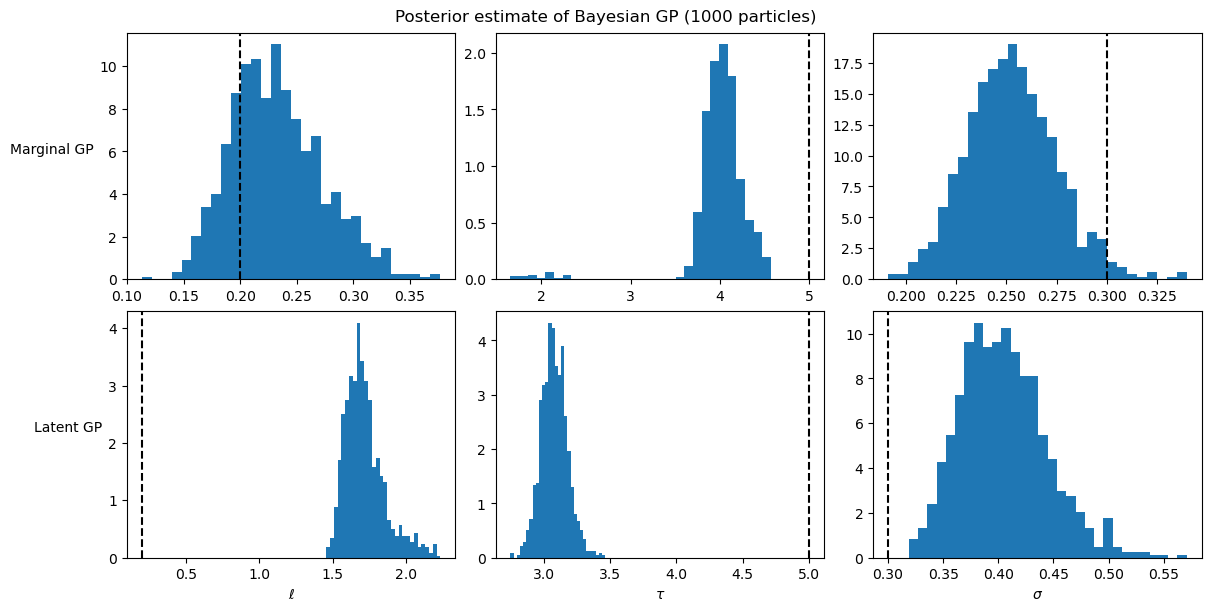

In [12]:
symbols = dict(lengthscale='\ell',
               obs_noise='\sigma',
               variance=r'\tau')

trainables = list()
for component, val in priors.items():
    trainables.extend(list(val.keys()))
trainables.remove('num')
# trainables.remove('loss')



num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])



_, axes = plt.subplots(nrows=2, ncols=num_params, constrained_layout=True,
                      figsize=(12, 6))

for m, particles in enumerate([mgp_particles, lgp_particles]):
    tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
            variance=particles.particles['kernel']['variance'],
            obs_noise=particles.particles['likelihood']['obs_noise']
            )
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = tr[var]
        # There are some outliers that skew the axis
        # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        # pd_filtered = jnp.extract(pd>pd_l, pd)
        # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd, bins=30, density=True, color='tab:blue')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

if len(ground_truth):
    for j, var in enumerate(trainables):
      if not(isinstance(ground_truth[var], float)):
        pass
        #[axes[0, j].axvline(x=_x, ls='--', c='k') for _x in ground_truth[var]]
        #[axes[1, j].axvline(x=_x, ls='--', c='k') for _x in ground_truth[var]]
      else:
        axes[0, j].axvline(x=ground_truth[var], ls='--', c='k');
        axes[1, j].axvline(x=ground_truth[var], ls='--', c='k');

CPU times: user 7.18 s, sys: 1.13 s, total: 8.31 s
Wall time: 5.45 s


Text(0.5, 0.98, 'Fitting standard GP to discontinuous data')

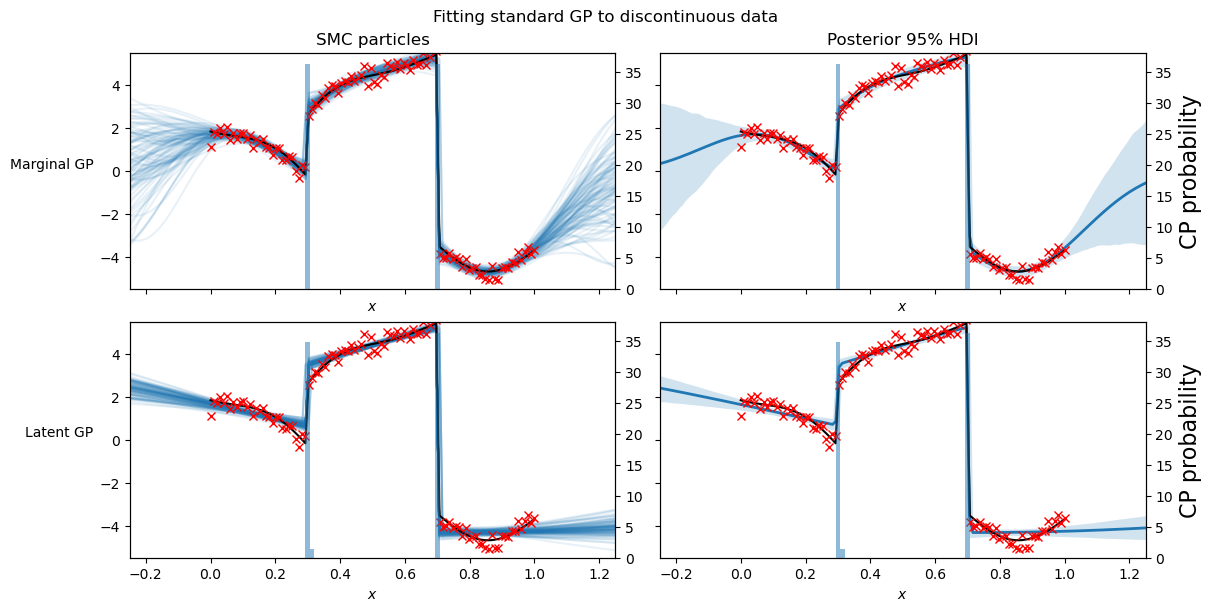

In [13]:
%%time

x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

for j, (gp, particles) in enumerate([[gp_marginal, mgp_particles], [gp_latent, lgp_particles]]):
    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    pd = particles.particles['kernel']['num'].flatten()
    # There are some outliers that skew the axis
    # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    # pd_filtered = jnp.extract(pd>pd_l, pd)
    # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    # print(pd_filtered.shape)

    ax = axes[j, 0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    ax2 = ax.twinx()
    ax2.hist(pd, bins=30, density=True, color='tab:blue', alpha=0.5)

    ax = axes[j, 1]
    f_mean = jnp.mean(f_pred, axis=0)
    f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

    ax2 = ax.twinx()
    ax2.hist(pd, bins=30, density=True, color='tab:blue', alpha=0.5)
    ax2.set_ylabel('CP probability', fontsize=16)



for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$')

axes[0, 0].set_title('SMC particles')
axes[0, 1].set_title('Posterior 95% HDI')

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

fig.suptitle('Fitting standard GP to discontinuous data')
# plt.show()
# plt.savefig("Marg_Latent_sigma_0.01_jitter_0.1_300part.png")

In [20]:
%%time

num_CP = len(x0)
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          CP=dx.Uniform(low=jnp.zeros(num_CP),
                                        high=jnp.ones(num_CP))
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

# gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
# gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

num_runs = 10
#fig, axes = plt.subplots(nrows = num_runs, 2, figsize=(12, 18))

all_gp_latent = []
# pd_all_mgp = jnp.zeros((num_particles*num_CP, num_runs))
f_pred_all = jnp.zeros((num_particles, 150, num_runs))
pd_all_lgp = jnp.zeros((num_particles*num_CP, num_runs))
key, key_pred = jrnd.split(key)
x_pred = jnp.linspace(-0.25, 1.25, num=150)

for i in range(num_runs):
  print(i)
  gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()
  # key, gpm_key = jrnd.split(key)
  # mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
  #                                                                   mode='gibbs-in-smc',
  #                                                                   sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))
  key, gpl_key = jrnd.split(key)
  lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))
  f_pred_all = f_pred_all.at[:, :, i].set(gp_latent.predict_f(key_pred, x_pred))
  pd_all_lgp = pd_all_lgp.at[:, i].set(lgp_particles.particles['kernel']['CP'].flatten())

0
1
2
3
4
5
6
7
8
9
CPU times: user 17min 5s, sys: 2.94 s, total: 17min 8s
Wall time: 16min 31s


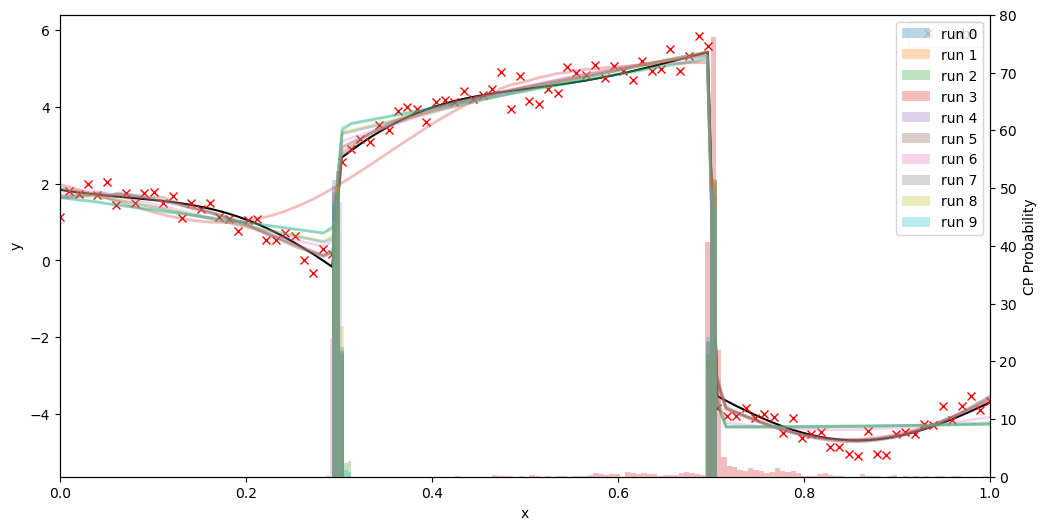

In [21]:
import matplotlib.colors as cm

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(x, f_true, 'k', label=r'')
ax1.plot(x, y, 'rx', label='obs')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim([0., 1.])
ax1.legend()

colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(num_runs)]

ax2 = ax1.twinx()
for i, c in zip(range(num_runs), colors):
  f_mean = jnp.mean(f_pred_all[:, :, i], axis=0)
  ax1.plot(x_pred, f_mean, color=c, lw=2, alpha = 0.3)
  ax2.hist(pd_all_lgp[:, i].T, bins=100, density=True, alpha = 0.3, color = c, label = f'run {i}')
ax2.set_ylabel('CP Probability')
ax2.legend()
# plt.show()
# plt.savefig("Latent_10_runs_nofactor_exp_temp_scale_10_jitter_1e-5_2")

New Latent method: Update num parameter seperately

In [8]:
num_CP = len(x0)
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=dx.Uniform(low=jnp.zeros(num_CP),
                                        high=jnp.ones(num_CP))
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp()))
                                                       )

# from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
gp_latent = FullLatentGPModel_new(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [9]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
CPU times: user 33.9 s, sys: 20.1 s, total: 54 s
Wall time: 52.3 s


In [15]:
%%time
from fullgp import FullLatentGPModel_new

gp_latent = FullLatentGPModel_new(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

key, gpl_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                mode='gibbs-in-smc',
                                                                sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 2min 20s, sys: 686 ms, total: 2min 21s
Wall time: 2min 17s


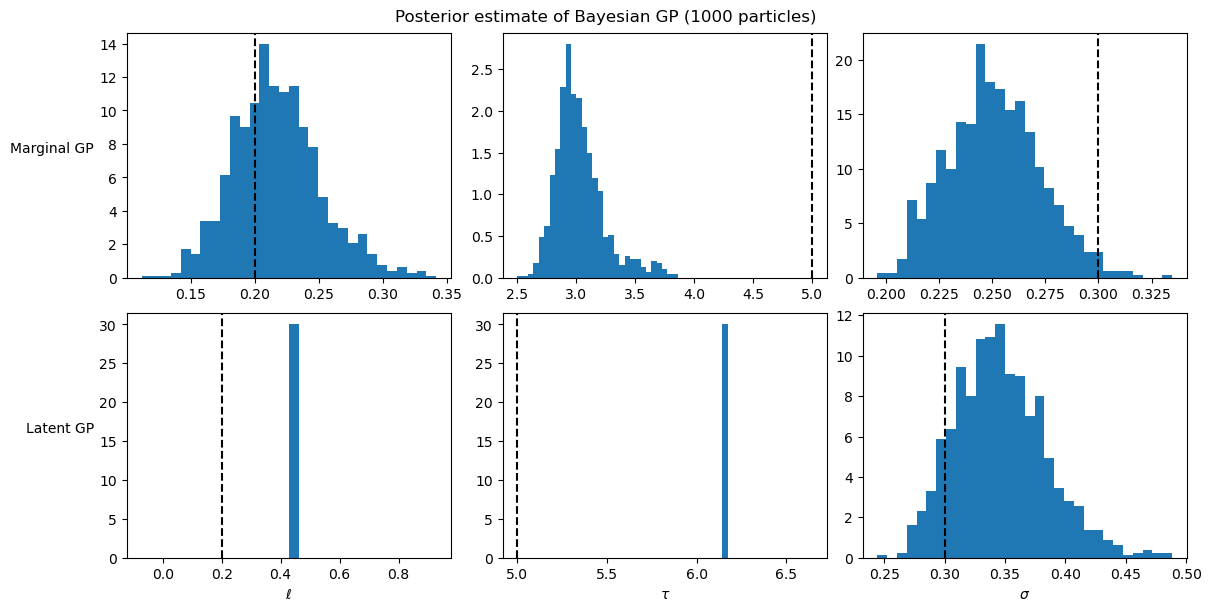

In [16]:
symbols = dict(lengthscale='\ell',
               obs_noise='\sigma',
               variance=r'\tau')

trainables = list()
for component, val in priors.items():
    trainables.extend(list(val.keys()))
trainables.remove('num')
# trainables.remove('loss')



num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])



_, axes = plt.subplots(nrows=2, ncols=num_params, constrained_layout=True,
                      figsize=(12, 6))

for m, particles in enumerate([mgp_particles, lgp_particles]):
    tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
            variance=particles.particles['kernel']['variance'],
            obs_noise=particles.particles['likelihood']['obs_noise']
            )
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = tr[var]
        # There are some outliers that skew the axis
        # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        # pd_filtered = jnp.extract(pd>pd_l, pd)
        # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd, bins=30, density=True, color='tab:blue')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

if len(ground_truth):
    for j, var in enumerate(trainables):
      if not(isinstance(ground_truth[var], float)):
        pass
        #[axes[0, j].axvline(x=_x, ls='--', c='k') for _x in ground_truth[var]]
        #[axes[1, j].axvline(x=_x, ls='--', c='k') for _x in ground_truth[var]]
      else:
        axes[0, j].axvline(x=ground_truth[var], ls='--', c='k');
        axes[1, j].axvline(x=ground_truth[var], ls='--', c='k');

CPU times: user 8.44 s, sys: 1.2 s, total: 9.64 s
Wall time: 5.55 s


Text(0.5, 0.98, 'Fitting standard GP to discontinuous data')

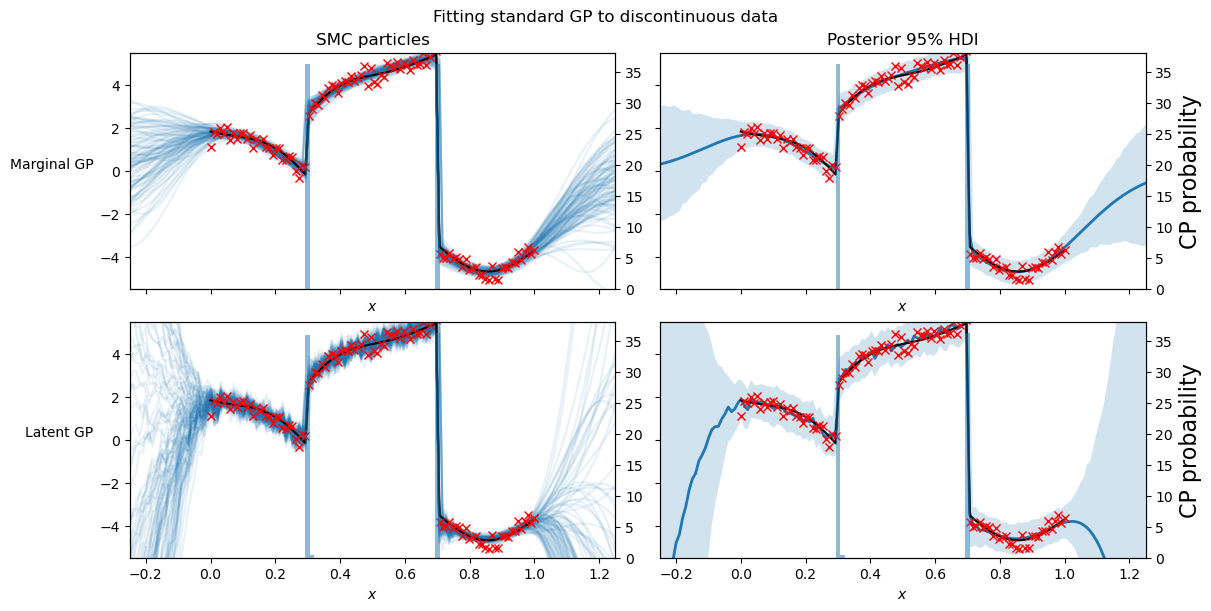

In [18]:
%%time

x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

for j, (gp, particles) in enumerate([[gp_marginal, mgp_particles], [gp_latent, lgp_particles]]):
    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    pd = particles.particles['kernel']['num'].flatten()
    # There are some outliers that skew the axis
    # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    # pd_filtered = jnp.extract(pd>pd_l, pd)
    # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    # print(pd_filtered.shape)

    ax = axes[j, 0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    ax2 = ax.twinx()
    ax2.hist(pd, bins=30, density=True, color='tab:blue', alpha=0.5)

    ax = axes[j, 1]
    f_mean = jnp.mean(f_pred, axis=0)
    y_pred = gp.predict_y(key_pred, x_pred)
    f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
    # f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    # f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

    ax2 = ax.twinx()
    ax2.hist(pd, bins=30, density=True, color='tab:blue', alpha=0.5)
    ax2.set_ylabel('CP probability', fontsize=16)



for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$')

axes[0, 0].set_title('SMC particles')
axes[0, 1].set_title('Posterior 95% HDI')

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

fig.suptitle('Fitting standard GP to discontinuous data')

Other data

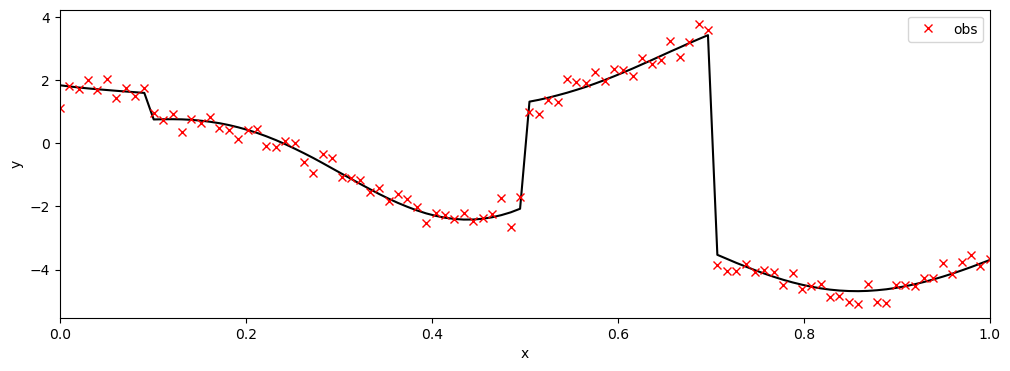

In [4]:
key = jrnd.PRNGKey(12345)

lengthscale_ = 0.2
output_scale_ = 5.0
obs_noise_ = 0.3
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

x0 = jnp.array([10, 50, 70])/n
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num = x0),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    num=x0,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [5]:
from fullgp import FullLatentGPModel_new

num_CP = len(x0)
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=dx.Uniform(low=jnp.zeros(num_CP),
                                        high=jnp.ones(num_CP))
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp()))
                                                       )

# from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
gp_latent = FullLatentGPModel_new(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [6]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
CPU times: user 33.5 s, sys: 19.8 s, total: 53.3 s
Wall time: 51.6 s


In [8]:
%%time
from fullgp import FullLatentGPModel_new

gp_latent = FullLatentGPModel_new(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

key, gpl_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                mode='gibbs-in-smc',
                                                                sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

CPU times: user 2min 27s, sys: 382 ms, total: 2min 28s
Wall time: 2min 24s


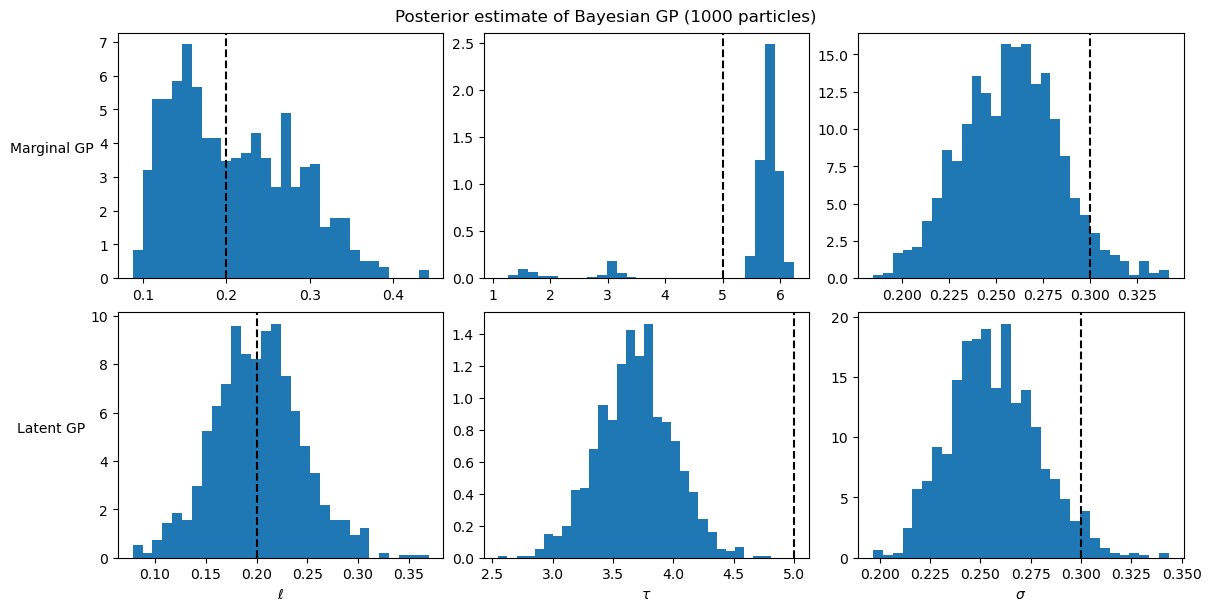

In [9]:
symbols = dict(lengthscale='\ell',
               obs_noise='\sigma',
               variance=r'\tau')

trainables = list()
for component, val in priors.items():
    trainables.extend(list(val.keys()))
trainables.remove('num')
# trainables.remove('loss')



num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])



_, axes = plt.subplots(nrows=2, ncols=num_params, constrained_layout=True,
                      figsize=(12, 6))

for m, particles in enumerate([mgp_particles, lgp_particles]):
    tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
            variance=particles.particles['kernel']['variance'],
            obs_noise=particles.particles['likelihood']['obs_noise']
            )
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = tr[var]
        # There are some outliers that skew the axis
        # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        # pd_filtered = jnp.extract(pd>pd_l, pd)
        # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd, bins=30, density=True, color='tab:blue')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

if len(ground_truth):
    for j, var in enumerate(trainables):
      if not(isinstance(ground_truth[var], float)):
        pass
        #[axes[0, j].axvline(x=_x, ls='--', c='k') for _x in ground_truth[var]]
        #[axes[1, j].axvline(x=_x, ls='--', c='k') for _x in ground_truth[var]]
      else:
        axes[0, j].axvline(x=ground_truth[var], ls='--', c='k');
        axes[1, j].axvline(x=ground_truth[var], ls='--', c='k');

CPU times: user 10.6 s, sys: 1.51 s, total: 12.1 s
Wall time: 7.49 s


Text(0.5, 0.98, 'Fitting standard GP to discontinuous data')

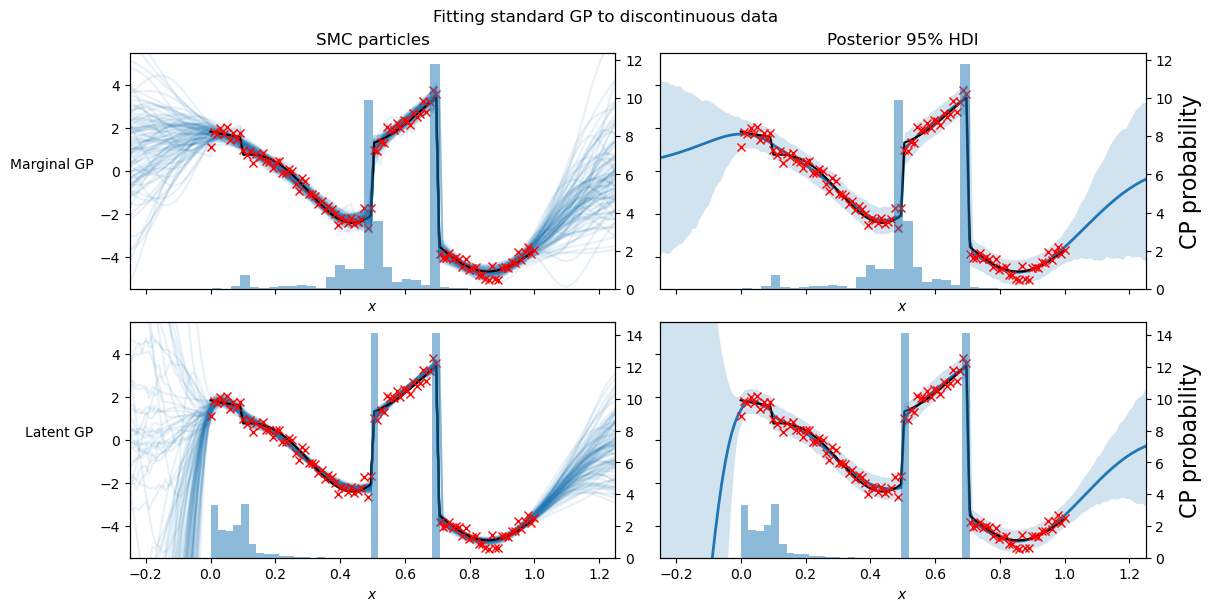

In [10]:
%%time

x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

for j, (gp, particles) in enumerate([[gp_marginal, mgp_particles], [gp_latent, lgp_particles]]):
    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    pd = particles.particles['kernel']['num'].flatten()
    # There are some outliers that skew the axis
    # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    # pd_filtered = jnp.extract(pd>pd_l, pd)
    # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    # print(pd_filtered.shape)

    ax = axes[j, 0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    ax2 = ax.twinx()
    ax2.hist(pd, bins=30, density=True, color='tab:blue', alpha=0.5)

    ax = axes[j, 1]
    f_mean = jnp.mean(f_pred, axis=0)
    y_pred = gp.predict_y(key_pred, x_pred)
    f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
    # f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    # f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

    ax2 = ax.twinx()
    ax2.hist(pd, bins=30, density=True, color='tab:blue', alpha=0.5)
    ax2.set_ylabel('CP probability', fontsize=16)



for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$')

axes[0, 0].set_title('SMC particles')
axes[0, 1].set_title('Posterior 95% HDI')

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

fig.suptitle('Fitting standard GP to discontinuous data')

In [11]:
%%time
from fullgp import FullLatentGPModel_new

num_CP = 3
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)

priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          num=dx.Uniform(low=jnp.zeros(num_CP),
                                        high=jnp.ones(num_CP))
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

# gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
# gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

num_runs = 10
#fig, axes = plt.subplots(nrows = num_runs, 2, figsize=(12, 18))

all_gp_latent = []
# pd_all_mgp = jnp.zeros((num_particles*num_CP, num_runs))
f_pred_all = jnp.zeros((num_particles, 150, num_runs))
pd_all_lgp = jnp.zeros((num_particles*num_CP, num_runs))
key, key_pred = jrnd.split(key)
x_pred = jnp.linspace(-0.25, 1.25, num=150)

for i in range(num_runs):
  print(i)
  gp_latent = FullLatentGPModel_new(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()
  # key, gpm_key = jrnd.split(key)
  # mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
  #                                                                   mode='gibbs-in-smc',
  #                                                                   sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))
  key, gpl_key = jrnd.split(key)
  lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))
  f_pred_all = f_pred_all.at[:, :, i].set(gp_latent.predict_f(key_pred, x_pred))
  pd_all_lgp = pd_all_lgp.at[:, i].set(lgp_particles.particles['kernel']['num'].flatten())

0
1
2
3
4
5
6
7
8
9
CPU times: user 23min 54s, sys: 4.17 s, total: 23min 58s
Wall time: 23min 22s


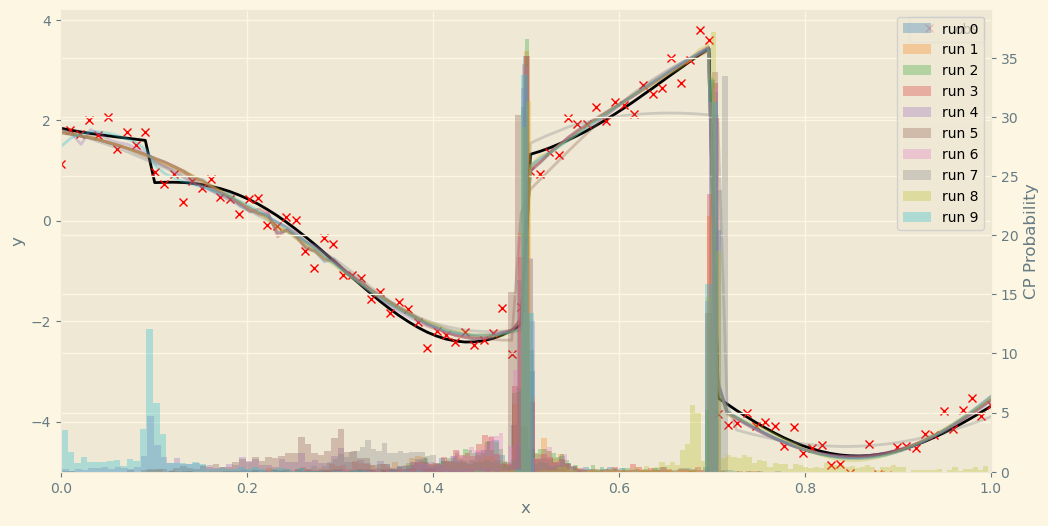

In [12]:
import matplotlib.colors as cm
plt.style.use('Solarize_Light2')

key = jrnd.PRNGKey(12345)

lengthscale_ = 0.2
output_scale_ = 5.0
obs_noise_ = 0.3
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

x0 = jnp.array([10, 50, 70])/n
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num = x0),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    CP=x0,
                    obs_noise=obs_noise_)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(x, f_true, 'k', label=r'')
ax1.plot(x, y, 'rx', label='obs')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim([0., 1.])
ax1.set_ylim([-5., 4.2])
ax1.legend();

#ax2 = ax1.twinx()
#ax2.hist(pd_all.T, bins=30, density=True, histtype='bar', stacked=True, alpha = 0.5)
#ax2.set_ylabel('CP Probability')
#plt.show()

colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(num_runs)]

ax2 = ax1.twinx()
for i, c in zip(range(num_runs), colors):
  f_mean = jnp.mean(f_pred_all[:, :, i], axis=0)
  ax1.plot(x_pred, f_mean, color=c, lw=2, alpha = 0.3)
  ax2.hist(pd_all_lgp[:, i].T, bins=100, density=True, alpha = 0.3, color = c, label = f'run {i}')
ax2.set_ylabel('CP Probability')
ax2.legend()
# plt.show()
# plt.savefig("Latent_10_runs_seperate_num_theta")

Testing Latent for learning multiple parameters and number of CPs

In [3]:
import sys
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult

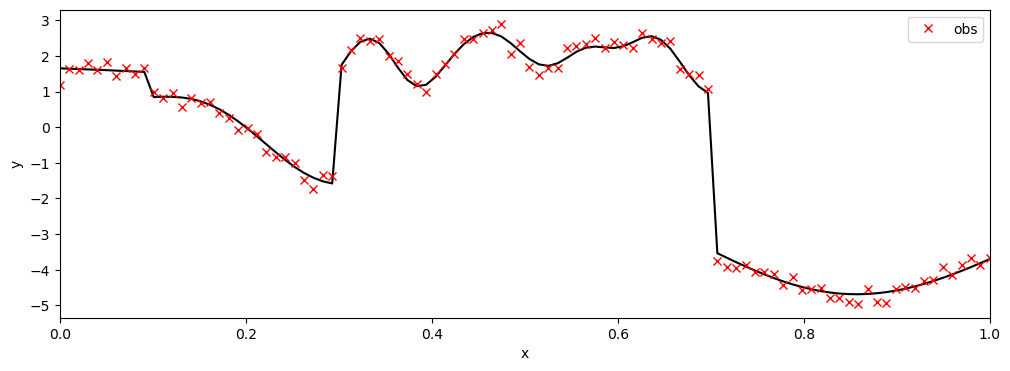

In [4]:
key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

# jnp.savez("f_true.npz", f_true)
jnp.savez("y.npz", X=y, doc_range = [0, 100])

In [11]:
# param = dict(lengthscale=lengthscale_,
#             variance=output_scale_,
#             num=x0)
# param

NameError: name 'lengthscale_' is not defined

Testing log probs for different amount of CPs

In [16]:
from uicsmodels.gaussianprocesses.meanfunctions import Zero
scale = 10
temperature = 1
jitter = 1e-5
X = jnp.linspace(0, 1, n)[:, jnp.newaxis] 
f = f_true
mu = Zero().mean(params=None, x=X)

## First set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1]), 
                  variance = jnp.array([1]), 
                  num = jnp.array([jnp.nan]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with zero CP: {log_pdf}")

## Second set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1]), 
                  variance = jnp.array([1, 1]), 
                  num = jnp.array([0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with 1 CP at right location: {log_pdf}")

## Third set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1]), 
                  variance = jnp.array([1, 1]), 
                  num = jnp.array([0.5]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with 1 CP at wrong location: {log_pdf}")

## Fourth set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), 
                  variance = jnp.array([1, 1, 1, 1, 1, 1]), 
                  num = jnp.array([0.3, 0.29, 0.31, 0.5, 0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with 5 CP: {log_pdf}")

## Fifth set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1, 0.1, 0.1, 0.1]), 
                  variance = jnp.array([1, 1, 1, 1, 1]), 
                  num = jnp.array([0.3, 0.31, 0.5, 0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with 4 CP (one removed from 5): {log_pdf}")

## Sixth set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1, 0.1, 0.1]), 
                  variance = jnp.array([1, 1, 1, 1]), 
                  num = jnp.array([0.3, 0.5, 0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with 3 CP (two removed from 5): {log_pdf}")

## Seventh set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1, 0.1]), 
                  variance = jnp.array([1, 1, 1]), 
                  num = jnp.array([0.3, 0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with 2 CP (three removed from 5): {log_pdf}")

## Eigth set of cov params: 
cov_params = dict(lengthscale = jnp.zeros(101)+0.2, 
                  variance = jnp.zeros(101)+1, 
                  num = jnp.linspace(0, 1, n))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with all CPs: {log_pdf}")

## True set of cov params: 
lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
# obs_noise_ = 0.2
# n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
cov_params = dict(lengthscale=lengthscale_,
                                variance=output_scale_,
                                num=x0)
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + jitter * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(f)
print(f"log pdf with correct values: {log_pdf}")

log pdf with zero CP: -932134.9912452626
log pdf with 1 CP at right location: -416111.7304415772
log pdf with 1 CP at wrong location: -827394.8564026165
log pdf with 5 CP: -23183.890740647406
log pdf with 4 CP (one removed from 5): -23222.094719905504
log pdf with 3 CP (two removed from 5): -24936.678760092316
log pdf with 2 CP (three removed from 5): -35797.98534678521
log pdf with all CPs: -475.0847454012094
log pdf with correct values: 299.7760585983766


Testing log prob for Marginal 

In [12]:
from uicsmodels.gaussianprocesses.meanfunctions import Zero
scale = 10
temperature = 1
jitter = 1e-5
X = jnp.linspace(0, 1, n)[:, jnp.newaxis] 
f = f_true
mu = Zero().mean(params=None, x=X)
sigma = 0.3

## First set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1]), 
                  variance = jnp.array([1]), 
                  num = jnp.array([jnp.nan]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with zero CP: {log_pdf}")

## Second set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1]), 
                  variance = jnp.array([1, 1]), 
                  num = jnp.array([0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with 1 CP at right location: {log_pdf}")

## Third set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1]), 
                  variance = jnp.array([1, 1]), 
                  num = jnp.array([0.5]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with 1 CP at wrong location: {log_pdf}")

## Fourth set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), 
                  variance = jnp.array([1, 1, 1, 1, 1, 1]), 
                  num = jnp.array([0.3, 0.29, 0.31, 0.5, 0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with 5 CP: {log_pdf}")

## Fifth set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.1, 0.1, 0.1, 0.1, 0.1]), 
                  variance = jnp.array([1, 1, 1, 1, 1]), 
                  num = jnp.array([0.3, 0.31, 0.5, 0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with 4 CP (one removed from 5): {log_pdf}")

## Sixth set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.2, 0.04, .05, 0.2]), 
                  variance = jnp.array([1, 1, 1, 1]), 
                  num = jnp.array([0.3, 0.5, 0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with 3 CP (two removed from 5): {log_pdf}")

## Seventh set of cov params: 
cov_params = dict(lengthscale = jnp.array([0.2, 0.04, 0.2]), 
                  variance = jnp.array([1, 1, 1]), 
                  num = jnp.array([0.3, 0.7]))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with 2 CP (three removed from 5): {log_pdf}")


## Eigth set of cov params: 
cov_params = dict(lengthscale = jnp.zeros(101)+0.2, 
                  variance = jnp.zeros(101)+1, 
                  num = jnp.linspace(0, 1, n))
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with all CPs: {log_pdf}")

## True set of cov params: 
lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
# obs_noise_ = 0.2
# n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
cov_params = dict(lengthscale=lengthscale_,
                                variance=output_scale_,
                                num=x0)
cov_fn = Discontinuous_multiple_params_hyper(jk.RBF(), temp=((scale**(1-temperature)-1)/(scale-1)))
cov_ = cov_fn.cross_covariance(params=cov_params, x=X, y=X) + (sigma ** 2 + jitter) * jnp.eye(n)
log_pdf = dx.MultivariateNormalFullCovariance(mu, cov_).log_prob(y)
print(f"log pdf with correct values: {log_pdf}")

log pdf with zero CP: -277.64533779705977
log pdf with 1 CP at right location: -152.92279369927627
log pdf with 1 CP at wrong location: -269.0904838594749
log pdf with 5 CP: -59.4313090848279
log pdf with 4 CP (one removed from 5): -57.72947189153146
log pdf with 3 CP (two removed from 5): -44.4784191200707
log pdf with 2 CP (three removed from 5): -44.31432778740509
log pdf with all CPs: -454.03933199981367
log pdf with correct values: -35.57650903632623


In [6]:
size = 10
T = 1
max_CP = size
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)

priors = dict(kernel=dict(lengthscale=LogNormal_mod(0, 3, max_CP+1),
                          variance=LogNormal_mod(0.5, 1, max_CP+1), 
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=1.,
                                                               scale=1.),
                                                     tfb.Exp())))

gp_latent = FullLatentGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

# num_particles = 1_000
# num_mcmc_steps = 1000

In [29]:
%%time
from fullgp import FullLatentGPModelhyper_mult
gp_latent = FullLatentGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1000
num_mcmc_steps = 100
key, gpm_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps),
                                                                  poisson = True)

In [56]:
# val = jnp.array([0.40557457, 0.54645722, 0.91968077,jnp.nan,jnp.nan,jnp.nan,jnp.nan, jnp.nan, jnp.nan, jnp.nan])
# dist = LogNormal_mod(0, 1, 10)
# prob = dist.log_prob(val)
# prob

Text(0, 0.5, 'variance')

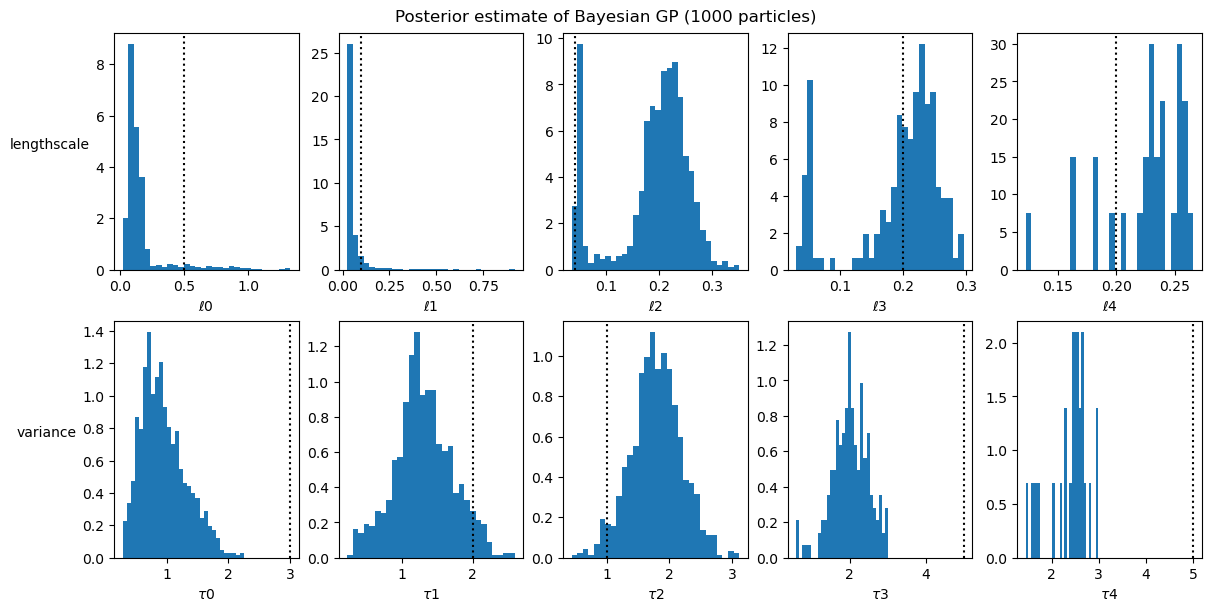

In [57]:
trainables = ['lengthscale', 'variance']

num_params = len(trainables)

symbols = dict(lengthscale='\ell',
            variance=r'\tau')
num_CP = 4
_, axes = plt.subplots(nrows=num_params, ncols=num_CP+1, constrained_layout=True,
                    figsize=(12, 6))


particles = lgp_particles
tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
            variance=particles.particles['kernel']['variance'],
            )
for j, var in enumerate(trainables):
    pd = tr[var]
    for i in range(num_CP+1):
      # There are some outliers that skew the axes
      pd_u, pd_l = jnp.nanpercentile(pd[:, i], q=99.9), jnp.nanpercentile(pd[:, i], q=0.1)
      pd_filtered = jnp.extract(pd[:, i]>pd_l, pd[:, i])
      pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
      axes[j, i].hist(pd_filtered[~jnp.isnan(pd_filtered)], bins=30, density=True, color='tab:blue')
      # axes[j, i].hist(pd[:, i][~jnp.isnan(pd[:, i])], bins=30, density=True, color='tab:blue')
      axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

      if var in symbols:
          axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))



plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')

Text(0, 0.5, 'Latent GP')

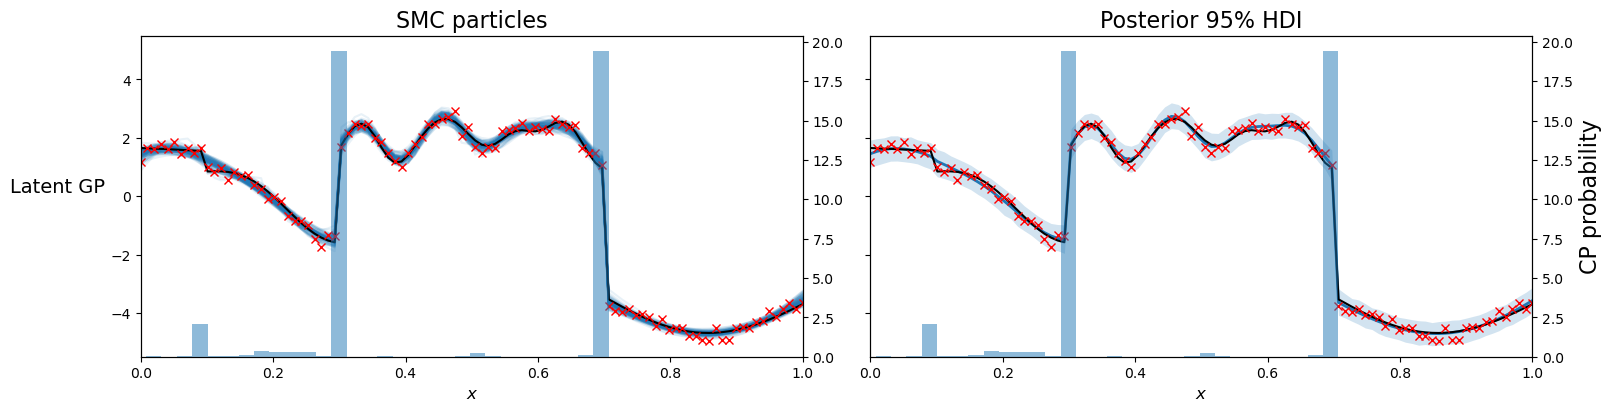

In [58]:
from scipy import stats
# plt.style.use('Solarize_Light2')
plt.style.use('default')


x_pred = jnp.linspace(0, 1, num=100)
# x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_latent.predict_f(key_pred, x_pred)

pd = lgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)


ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
# kde = stats.gaussian_kde(new_pd)
ax2 = ax.twinx()
# ax2.plot(x_pred, kde(x_pred))
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.nanmean(f_pred, axis=0)
y_pred = gp_latent.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)
ax2 = ax.twinx()
# ax2.plot(x_pred, kde(x_pred))
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0., 1])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Latent GP', rotation=0, ha='right', fontsize=14)

In [18]:
# l = lgp_particles.particles['kernel']['lengthscale']
# v = lgp_particles.particles['kernel']['variance']

# nan_l = jnp.sum(l < 0, axis = 1)
# nan_v = jnp.sum(v < 0, axis = 1)
# print(v[20:30])

In [17]:
# print(pd[20:30])

In [40]:
jnp.sum(jnp.sum(jnp.isnan(f_pred), axis = 1) > 0)

Array(152, dtype=int64)

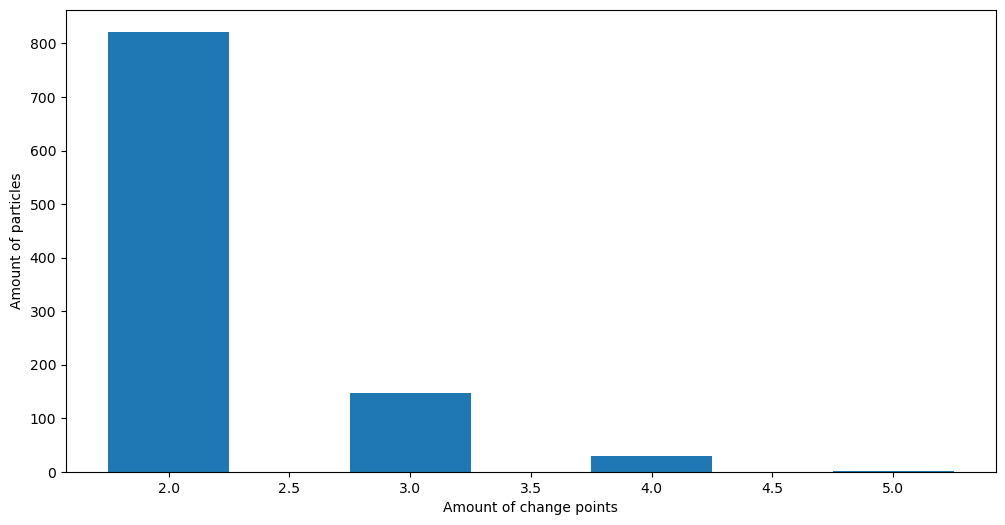

In [59]:
fig = plt.figure(figsize=(12, 6))
num_val = lgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.show()

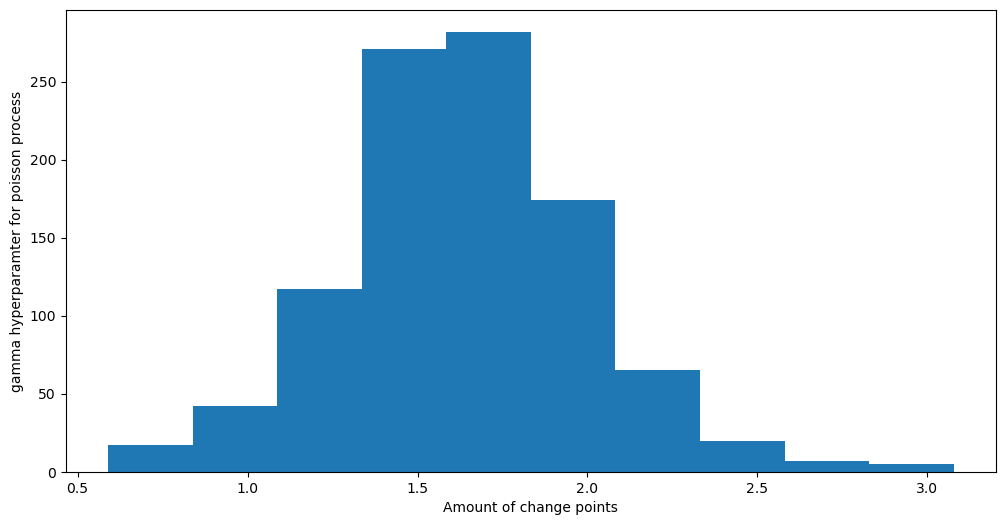

In [16]:
fig = plt.figure(figsize=(12, 6))
plt.hist(lgp_particles.particles['hyper']['hyper_pp'])
plt.xlabel("Amount of change points")
plt.ylabel("gamma hyperparamter for poisson process")
plt.show()

### Testing up to 0.3 temp

In [11]:
sys.path.append('/home/davcic/CP_Testing/Classes')
sys.path.append('/home/davcic/CP_Testing')
from Cauchy_likelihood import Cauchy

from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1000
num_mcmc_steps = 100
GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps, likelihood = Cauchy())

In [12]:
GP_latent.model_GP(key)

Running Latent GP


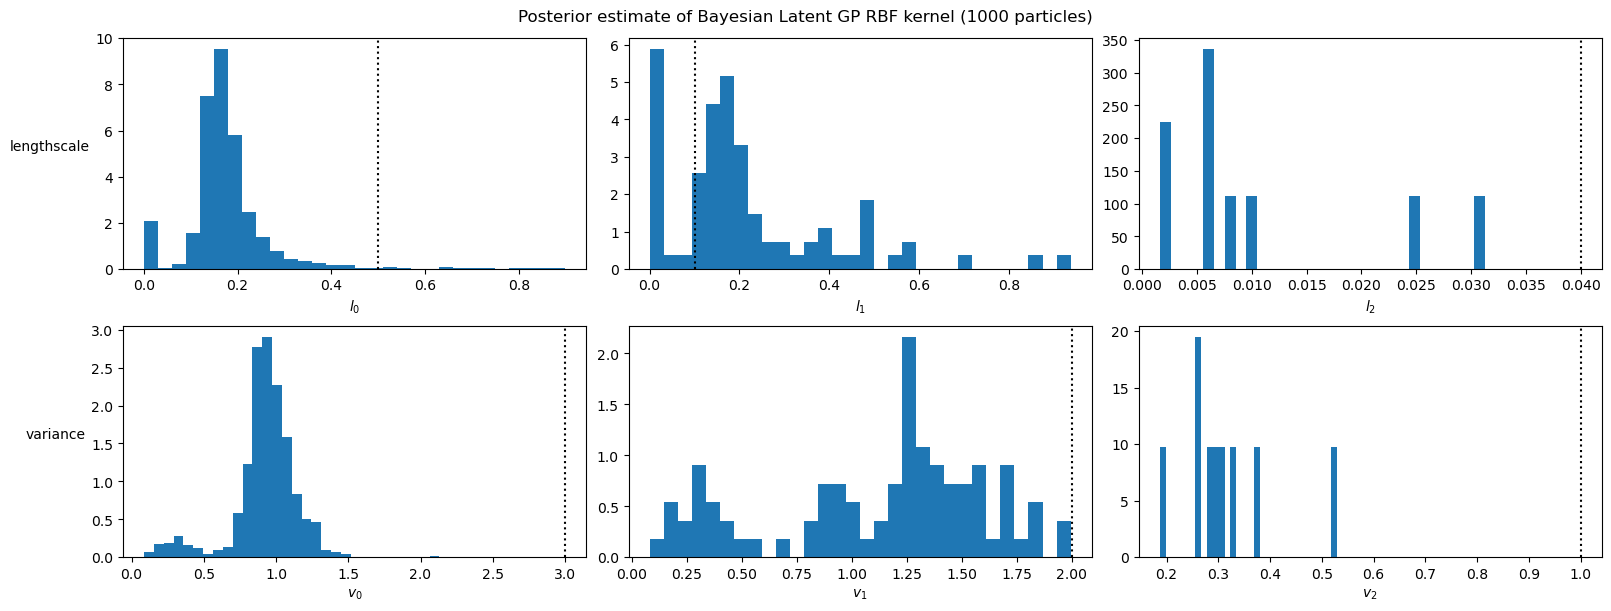

In [74]:
GP_latent.plot_post(ground_truth)

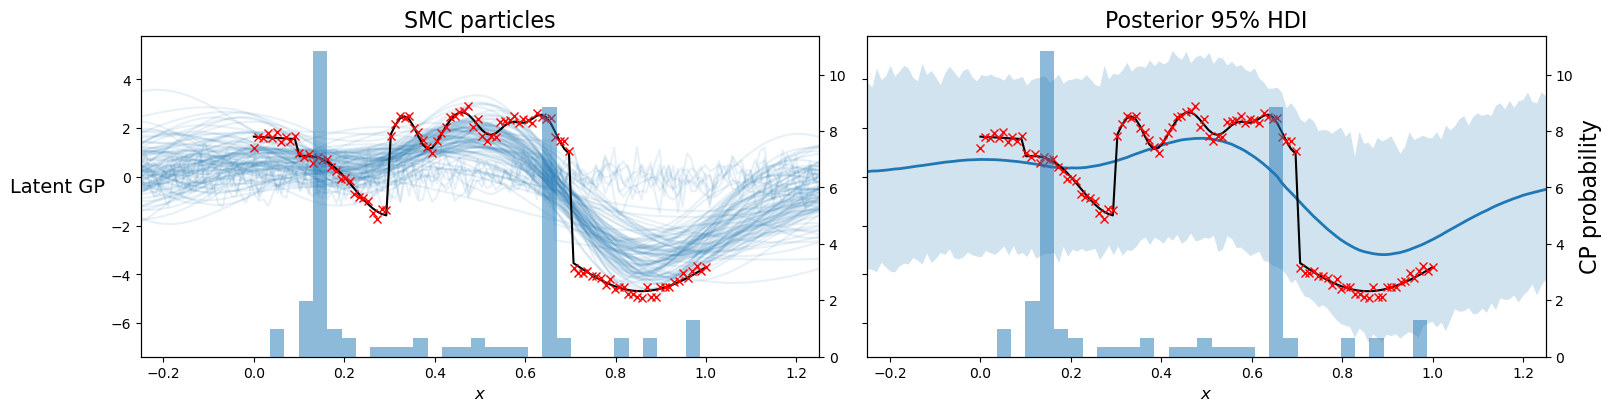

In [75]:
GP_latent.plot_fit(key, True, f_true, ground_truth)

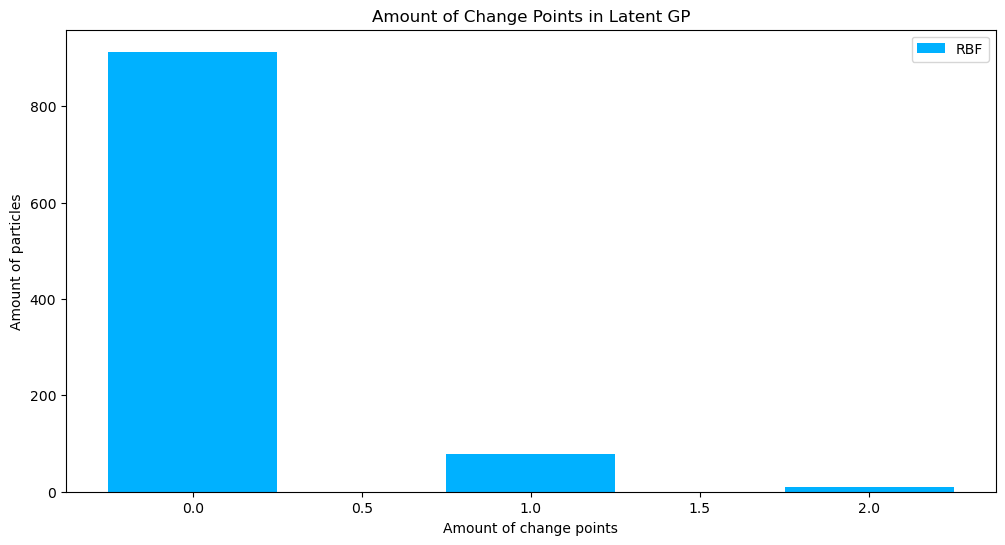

In [76]:
GP_latent.plot_num()

### Testing Gibbs sampling over each dimension separately

In [7]:
sys.path.append('/home/davcic/CP_Testing/Classes')

from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1000
num_mcmc_steps = 1000
GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

KeyError: 'likelihood'

In [47]:
GP_latent.model_GP(key)

Running Latent GP


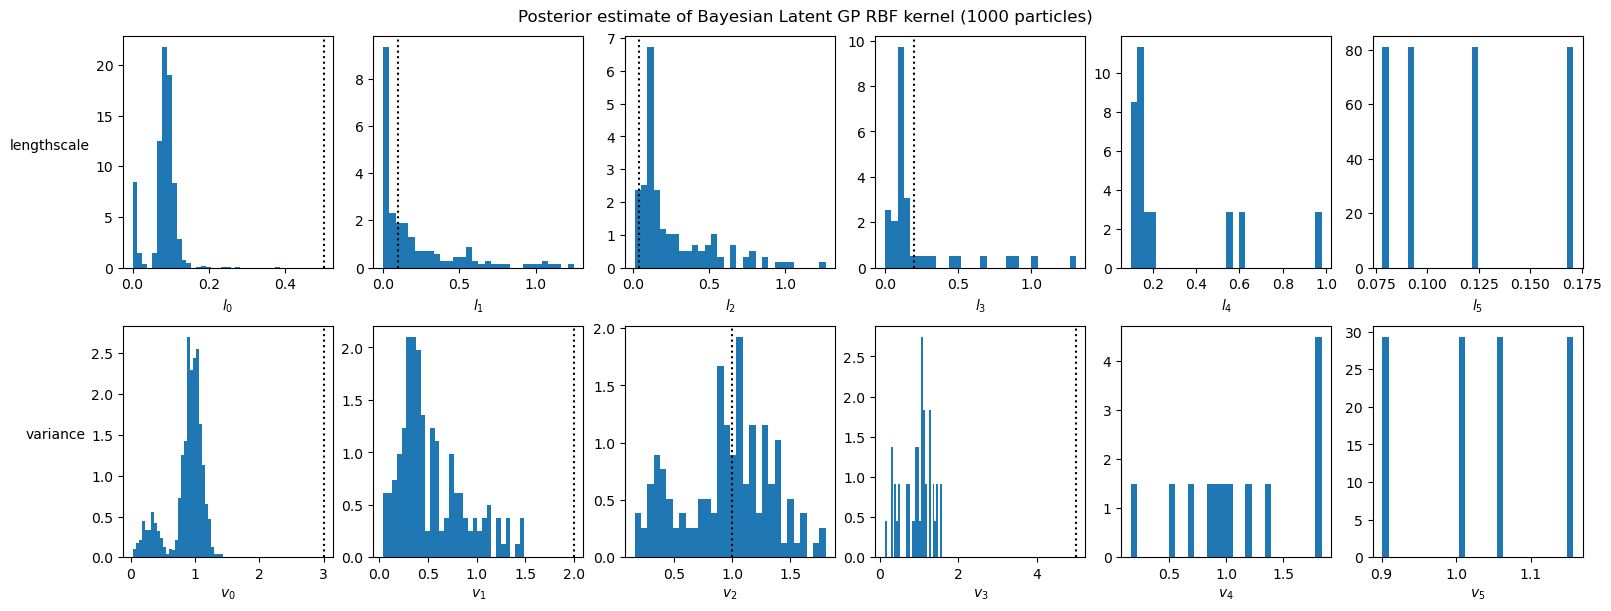

In [48]:
ground_truth = dict(f=f_true,
                    kernel = dict(lengthscale=lengthscale_,
                                    variance=output_scale_,
                                    num = x0),
                    obs_noise=obs_noise_,
                    )
GP_latent.plot_post(ground_truth)

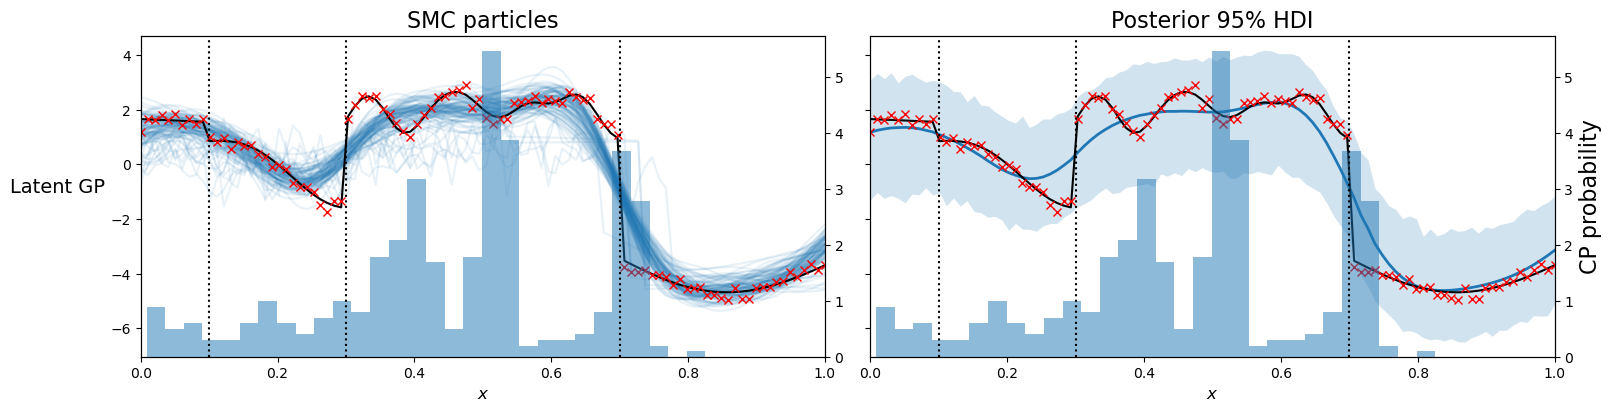

In [49]:
GP_latent.plot_fit(key, False, f_true, ground_truth)

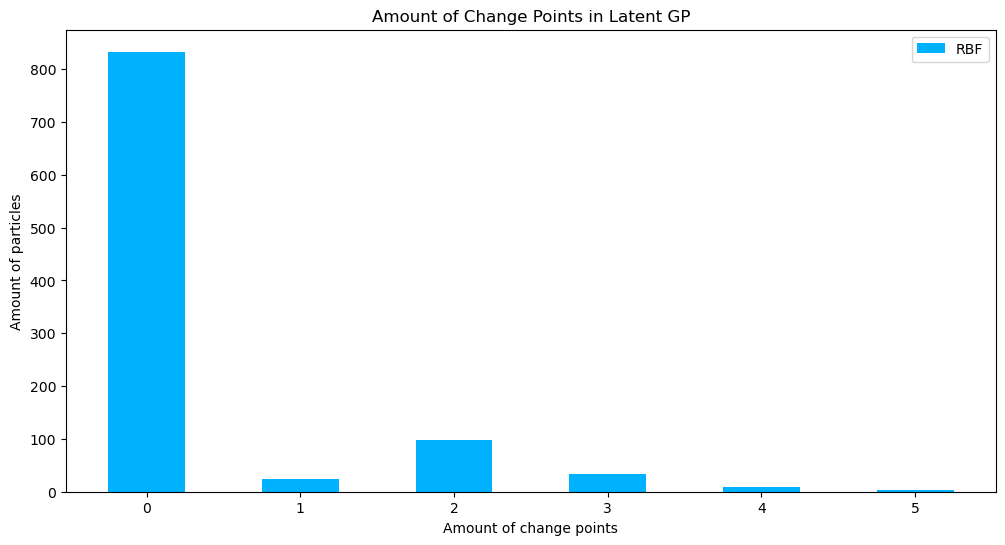

In [50]:
GP_latent.plot_num()